In [85]:
!pip install statsmodels
!pip install pmdarima
!pip install scikit-learn
!pip install pandas
!pip install seaborn
!pip install scikit-learn
!pip install openpyxl
!pip install matplotlib

In [125]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt 
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import matplotlib
%matplotlib inline
import seaborn as sns
pd.options.display.max_rows=50
pd.options.display.max_columns=50
from pmdarima import auto_arima #uses data trail and error and gives best pqd values
from sklearn.preprocessing import MinMaxScaler #for lstm in case we use
from sklearn.metrics import r2_score #for lstm in case we use
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(15,4)
matplotlib.rcParams['axes.labelsize']=14
matplotlib.rcParams['xtick.labelsize']=12
matplotlib.rcParams['ytick.labelsize']=12
matplotlib.rcParams['text.color']='k'

In [126]:
cd downloads


[WinError 2] The system cannot find the file specified: 'downloads'
C:\Users\munee\downloads


In [127]:
data=pd.read_excel('POCM_HISTORICAL.xlsx',engine='openpyxl')

In [128]:
data.head()

,Checkout_Date,Order_Nbr,Item_Nbr,Zip_Code,WSLR_Nbr,Ship_Date,Brand,Partition,Item_Description,Category,Carton_Factor,City,State,Supplier,Lead_Date_in_Weeks,Brand_Code,Cost,Item_Active,Weekly_Avg_Qty_Sold,On_Hand_Inventory,On_Order_Inventory,Pending_WO_Inventory,Remaining_Inventory_Weeks,Order_Quantity,LastModId,LastModMachine,LastModApp,LastModTsp
0,2018-12-04,100003,5000268,63118,0,2018-12-05,Bud Light - Core,Core,Bud Light Satin Flag,POCM,1,ST LOUIS,MO,IMS,12.0,BDL,12.0,1,NaN,112,0.0,0,22.0,1,ABC\Z926679,NAZUSD5S21H13,Microsoft SQL Server Management Studio - Query,2020-04-28 14:55:10
1,2018-12-04,100012,1093107,10011,0,2018-12-07,Bud Light - Core,Core,Base Stacker,POCM,1,New York,NY,IMS,10.0,BDL,28.0,0,NaN,0,0.0,0,52.0,1,ABC\Z926679,NAZUSD5S21H13,Microsoft SQL Server Management Studio - Query,2020-04-28 14:55:10
2,2018-12-05,100030,1090635,20772,0,2018-12-13,Michelob ULTRA - Core +,Core +,NEON - MICHELOB ULTRA,POCM,1,UPPER MARLBORO,MD,IMS,8.0,MUL,93.0,0,NaN,0,0.0,0,52.0,5,ABC\Z926679,NAZUSD5S21H13,Microsoft SQL Server Management Studio - Query,2020-04-28 14:55:10
3,2018-12-05,100030,5003134,20772,0,2018-12-13,Stella Artois - Super Premium - Import,Import,LED Neon Sign,POCM,1,UPPER MARLBORO,MD,IMS,8.0,STA,80.0,0,NaN,0,0.0,0,52.0,10,ABC\Z926679,NAZUSD5S21H13,Microsoft SQL Server Management Studio - Query,2020-04-28 14:55:10
4,2018-12-05,100030,5007384,20772,0,2018-12-13,Michelob ULTRA - Core +,Core +,Umbrella,POCM,1,UPPER MARLBORO,MD,IMS,16.0,MUL,41.5,0,NaN,0,0.0,0,52.0,20,ABC\Z926679,NAZUSD5S21H13,Microsoft SQL Server Management Studio - Query,2020-04-28 14:55:10


In [129]:
#POCM here inorder to understand howmany rows and days of data they provided

In [160]:
df=data[["Checkout_Date","Order_Quantity"]]
date=data[["Checkout_Date","Order_Quantity"]]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160577 entries, 0 to 160576
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Checkout_Date   160577 non-null  datetime64[ns]
 1   Order_Quantity  160577 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.5 MB


In [161]:
df["Checkout_Date"].max()-df["Checkout_Date"].min()

Timedelta('528 days 00:00:00')

In [162]:
df["DayOfWeek"]=df["Checkout_Date"].dt.day_name()
print(df["DayOfWeek"])
df["month_name"]=df["Checkout_Date"].dt.month_name()
print(df["month_name"])

0           Tuesday
1           Tuesday
2         Wednesday
3         Wednesday
4         Wednesday
            ...    
160572       Friday
160573       Friday
160574       Friday
160575       Friday
160576       Friday
Name: DayOfWeek, Length: 160577, dtype: object
0         December
1         December
2         December
3         December
4         December
            ...   
160572         May
160573         May
160574         May
160575         May
160576         May
Name: month_name, Length: 160577, dtype: object


In [163]:
df.set_index("Checkout_Date",inplace=True)

In [164]:
df

,Order_Quantity,DayOfWeek,month_name
Checkout_Date,,,
2018-12-04,1,Tuesday,December
2018-12-04,1,Tuesday,December
2018-12-05,5,Wednesday,December
2018-12-05,10,Wednesday,December
2018-12-05,20,Wednesday,December
...,...,...,...
2020-05-15,5,Friday,May
2020-05-15,20,Friday,May
2020-05-15,2,Friday,May


In [165]:
#Understand weekly order quantity mean

In [166]:
# Ensure the index is of datetime type
df.index = pd.to_datetime(df.index)

# Resample using a grouper
grouper = df.index.to_period('W').to_timestamp()

# Calculate mode using groupby
weekly_df = df.groupby(grouper).agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)

print(weekly_df)

               Order_Quantity DayOfWeek month_name
Checkout_Date                                     
2018-12-03                 10    Friday   December
2018-12-10                 10    Monday   December
2018-12-17                 10   Tuesday   December
2018-12-24                 10  Thursday   December
2018-12-31                 10    Friday    January
...                       ...       ...        ...
2020-04-13                  1   Tuesday      April
2020-04-20                  2  Thursday      April
2020-04-27                  1    Friday        May
2020-05-04                  1  Thursday        May
2020-05-11                  2  Thursday        May

[76 rows x 3 columns]


In [167]:
weekly_df

,Order_Quantity,DayOfWeek,month_name
Checkout_Date,,,
2018-12-03,10,Friday,December
2018-12-10,10,Monday,December
2018-12-17,10,Tuesday,December
2018-12-24,10,Thursday,December
2018-12-31,10,Friday,January
...,...,...,...
2020-04-13,1,Tuesday,April
2020-04-20,2,Thursday,April
2020-04-27,1,Friday,May


MemoryError: Unable to allocate 5.82 GiB for an array with shape (781490137,) and data type int64

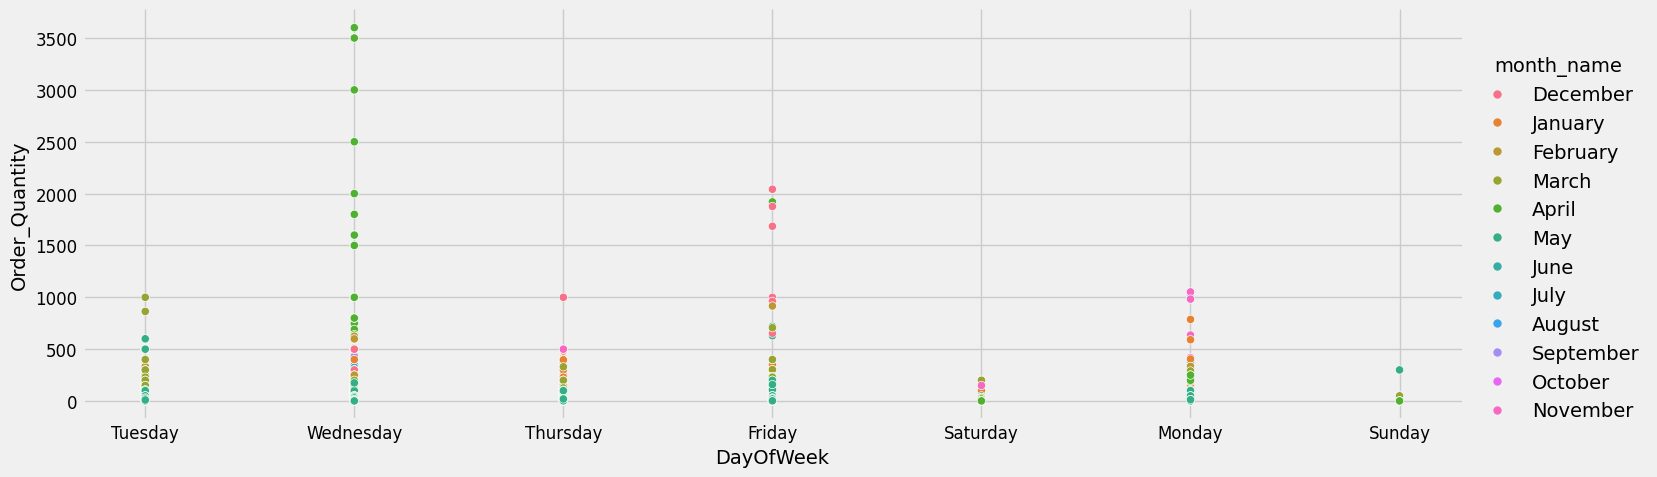

In [168]:
sns.relplot(x="DayOfWeek", y="Order_Quantity",hue="month_name",data=df,height=5,aspect=3) #consider this with full data even if error 

In [ ]:
# Reducing the size of the DataFrame to prevent MemoryError
#df_sampled = df.sample(frac=0.1, random_state=1)  # Adjust fraction as needed

#sns.relplot(x="DayOfWeek", y="Order_Quantity", hue="month_name", data=df_sampled, height=5, aspect=3)


In [169]:
df.loc[df["Order_Quantity"]>2000]

,Order_Quantity,DayOfWeek,month_name
Checkout_Date,,,
2019-04-03,3000,Wednesday,April
2019-04-03,3000,Wednesday,April
2019-04-03,2500,Wednesday,April
2019-04-03,2500,Wednesday,April
2019-04-03,3500,Wednesday,April
2019-04-03,3500,Wednesday,April
2019-04-03,3600,Wednesday,April
2019-12-06,2042,Friday,December


In [170]:
weekly_df

,Order_Quantity,DayOfWeek,month_name
Checkout_Date,,,
2018-12-03,10,Friday,December
2018-12-10,10,Monday,December
2018-12-17,10,Tuesday,December
2018-12-24,10,Thursday,December
2018-12-31,10,Friday,January
...,...,...,...
2020-04-13,1,Tuesday,April
2020-04-20,2,Thursday,April
2020-04-27,1,Friday,May


In [171]:
df.head()

,Order_Quantity,DayOfWeek,month_name
Checkout_Date,,,
2018-12-04,1,Tuesday,December
2018-12-04,1,Tuesday,December
2018-12-05,5,Wednesday,December
2018-12-05,10,Wednesday,December
2018-12-05,20,Wednesday,December


In [172]:
df_2020 =df.loc['2020']

In [173]:
df_2020

,Order_Quantity,DayOfWeek,month_name
Checkout_Date,,,
2020-01-01,12,Wednesday,January
2020-01-01,3,Wednesday,January
2020-01-02,10,Thursday,January
2020-01-02,30,Thursday,January
2020-01-02,12,Thursday,January
...,...,...,...
2020-05-15,5,Friday,May
2020-05-15,20,Friday,May
2020-05-15,2,Friday,May


In [174]:
daily_df=df.groupby(["Checkout_Date","DayOfWeek","month_name"])["Order_Quantity"].sum()
daily_df

Checkout_Date  DayOfWeek  month_name
2018-12-04     Tuesday    December         2
2018-12-05     Wednesday  December        79
2018-12-06     Thursday   December       422
2018-12-07     Friday     December       468
2018-12-08     Saturday   December       111
                                        ... 
2020-05-11     Monday     May           2749
2020-05-12     Tuesday    May           3366
2020-05-13     Wednesday  May           1491
2020-05-14     Thursday   May           6631
2020-05-15     Friday     May           1018
Name: Order_Quantity, Length: 470, dtype: int64

In [175]:
#TESTING STATIONARITY 

In [176]:
from statsmodels.tsa.stattools import adfuller

In [178]:
def adfuller_test(Order_Quantity):
    result=adfuller(Order_Quantity)
    labels=['ADF Test Statistic','p_value','#Lags Used','Number of observaions Used']
    
    for values,label in zip (result,labels):
        print(label+' : '+str(values))
    if result[1]<=0.05:
        print("Strong Evidence agaist null hypothesis(HO), reject the null hypotheis. Data has no unit root & is Stationary")
    else:
        print("weak evidence against null hypothesis, timeseries has a unit root, and is a alternate hypothesis")

In [180]:
# Reset index if necessary If the DataFrame daily_df has a MultiIndex or if 'Order_Quantity' is not directly accessible, you can reset the index to flatten the DataFrame:
daily_df_reset = daily_df.reset_index()


In [181]:
adfuller_test(daily_df_reset["Order_Quantity"])

ADF Test Statistic : -10.14719787490446
p_value : 8.127120756465995e-18
#Lags Used : 2
Number of observaions Used : 467
Strong Evidence agaist null hypothesis(HO), reject the null hypotheis. Data has no unit root & is Stationary


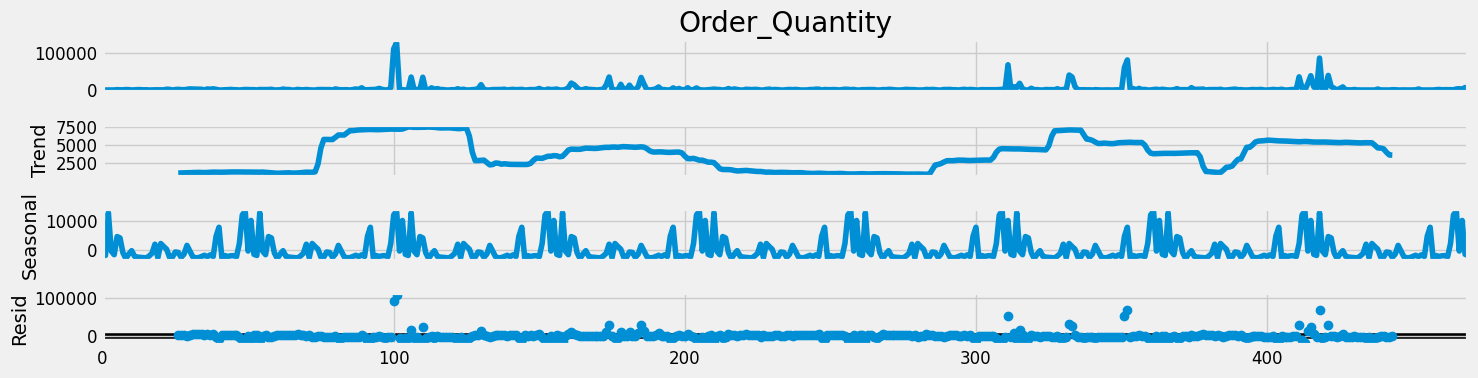

In [183]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
final=seasonal_decompose(daily_df_reset["Order_Quantity"],model='additive',period = 52)#no.of weeks
final.plot()
plt.show()


In [195]:
#find somewhat difficult to forecast seasonality is fluctuating finding 'higher sales on weekdays' and trend is also fluctuating

In [187]:
daily_df_reset=daily_df_reset[["Checkout_Date","Order_Quantity"]]
print(daily_df_reset.shape)

(470, 2)


In [190]:
train_size = int(len(daily_df_reset)*0.80)
train,test = daily_df_reset[0:train_size],daily_df_reset[train_size:]
print(train.shape,test.shape)

(376, 2) (94, 2)


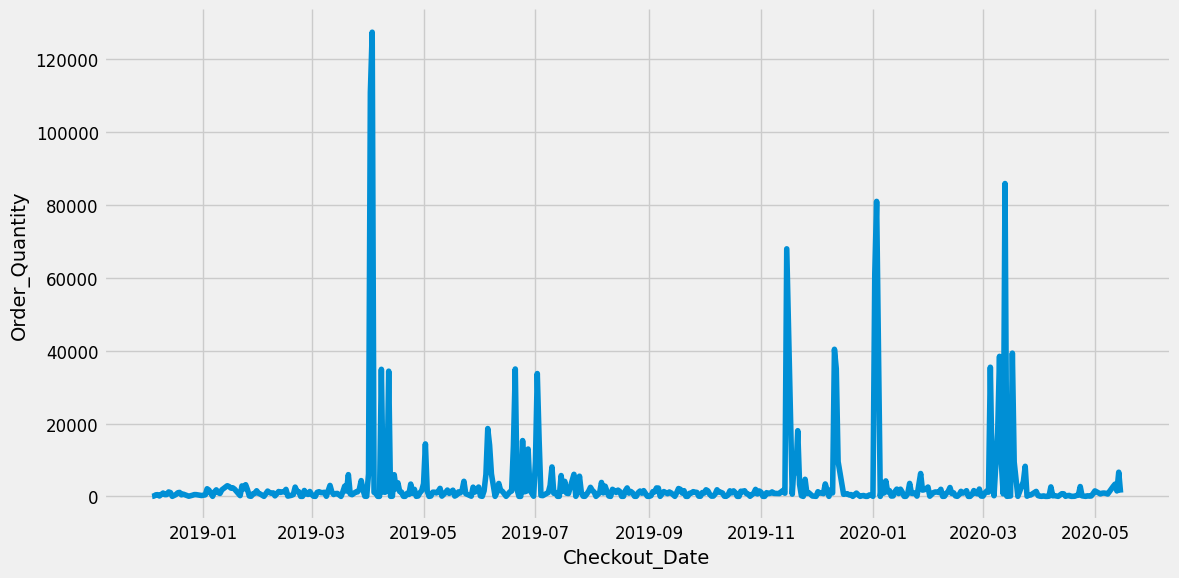

In [193]:
sns.relplot(x="Checkout_Date",y="Order_Quantity",data=daily_df_reset,kind='line',aspect=2,height=6)

In [196]:
#2019 'MAR' SPIKE IN STOCK AND 2020 'MAR' ALSO HAVE SOME SUPPLY WHAEREAS IN 'MAY' 2019 HAVE SOME SALES COMPARED TO 2020 'MAY'

In [197]:
#TO DECIDE AR OR MA MODEL WE ARE GOING WITH ACF AND PACF PLOTS

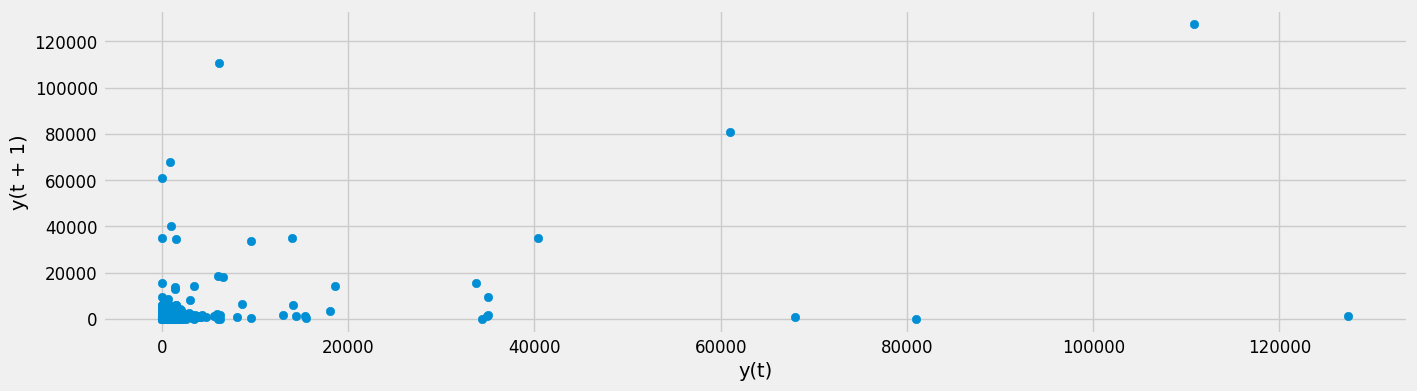

In [202]:
from pandas.plotting import lag_plot
lag_plot(train["Order_Quantity"])
plt.show()

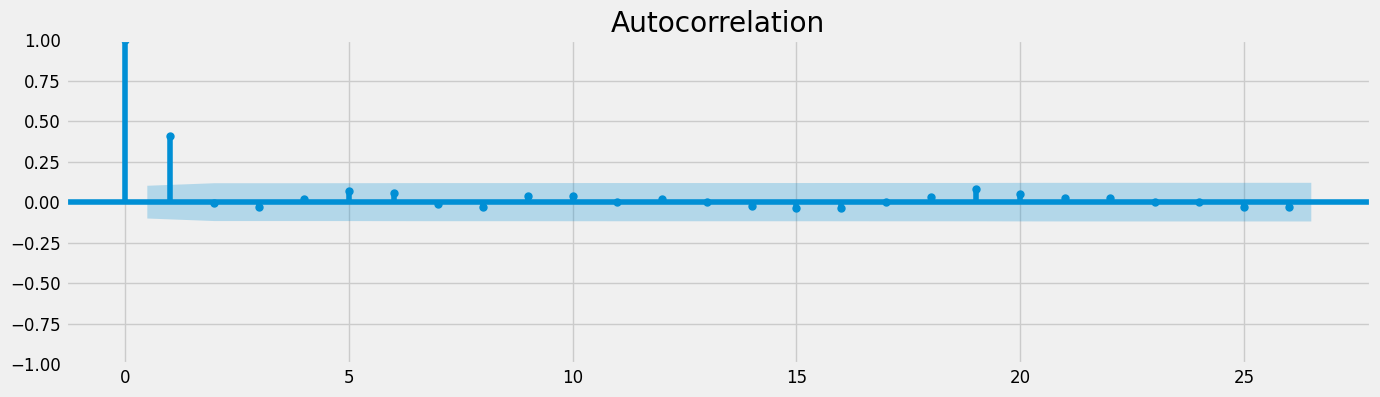

In [204]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(train["Order_Quantity"])
plt.show()

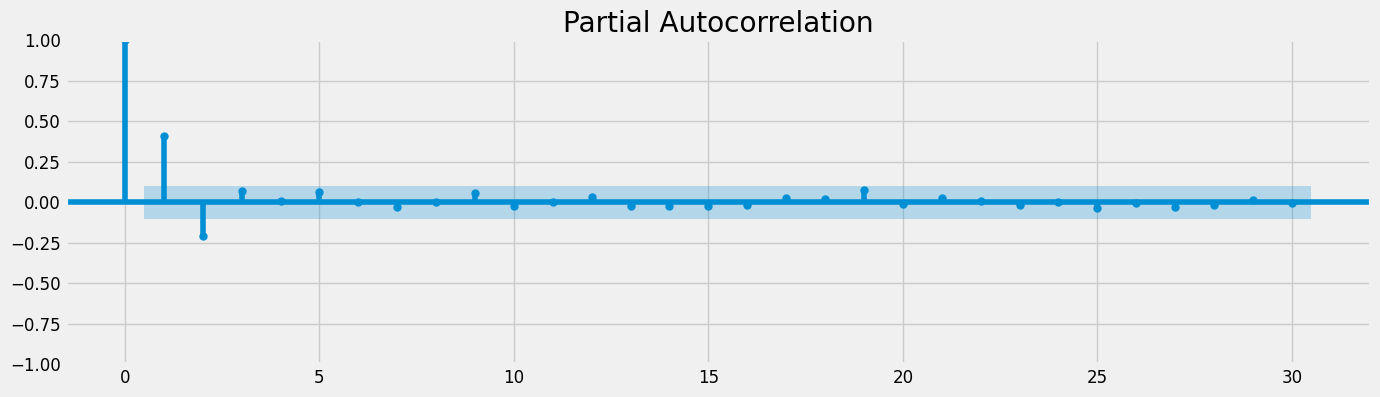

In [205]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(train["Order_Quantity"],lags=30)
plt.show()

In [206]:
#AS PER PLOTS ACF PACF THERE IS A SUDDEN DROP IN BOTH SO WE ARE NOR USING EITHER AR NOR MA MODEL WE ARE GOING WITH ARIMA

In [207]:
from pmdarima import auto_arima
stepwise_fit=auto_arima(train["Order_Quantity"],trace=True,suppress_warning=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=8027.429, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8106.163, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=8039.325, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8023.686, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8133.208, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=8024.974, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=8024.966, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=8025.949, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8036.372, Time=0.05 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.904 seconds


In [212]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(train["Order_Quantity"],order=(0,0,1))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         Order_Quantity   No. Observations:                  376
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -4007.991
Date:                Tue, 27 Aug 2024   AIC                           8021.983
Time:                        17:42:41   BIC                           8033.771
Sample:                             0   HQIC                          8026.662
                                - 376                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3275.6755    909.868      3.600      0.000    1492.368    5058.983
ma.L1          0.4938      0.014     35.496      0.000       0.467       0.521
sigma2      1.072e+08      0.355   3.02e+08      0.000    1.07e+08    1.07e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):             31676.66
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                             5.37
Prob(H) (two-sided):                  0.07   Kurtosis:                        46.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.75e+22. Standard errors may be unstable.
"""

In [213]:
model.predict()

0      3275.675532
1      1976.068844
2      2381.669674
3      2318.673634
4      2364.294457
          ...     
371    1849.217820
372    2751.173840
373    2404.068364
374    2120.690847
375    5329.458330
Name: predicted_mean, Length: 376, dtype: float64

<Axes: >

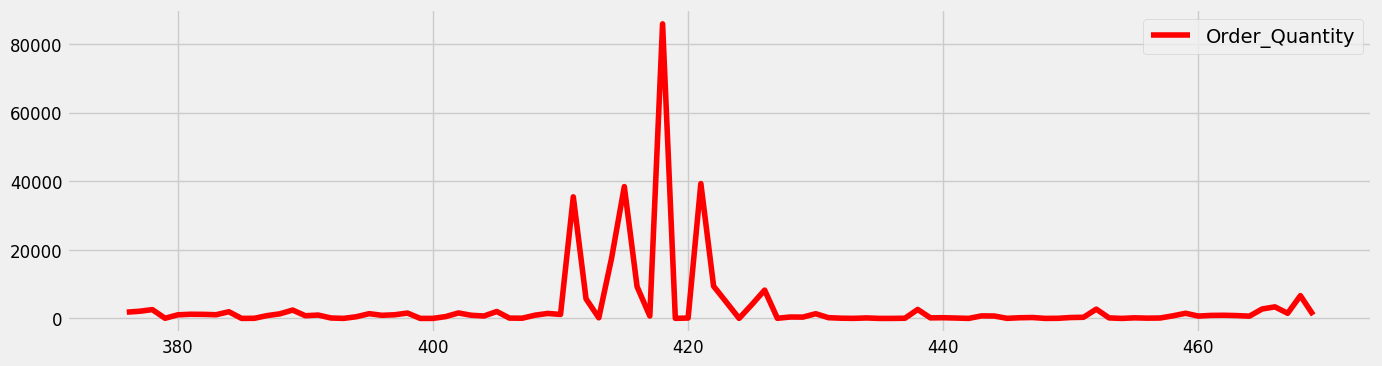

In [215]:
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start,end=end).rename('ARIMA prediction')
test["Order_Quantity"].plot(legend=True,color='red')

In [217]:
daily_df_reset["Order_Quantity"].mean()

3314.923404255319

In [220]:
model2=ARIMA(daily_df_reset["Order_Quantity"],order=(0,0,1))
model2:model2.fit()
test.tail()

,Checkout_Date,Order_Quantity
465,2020-05-11,2749
466,2020-05-12,3366
467,2020-05-13,1491
468,2020-05-14,6631
469,2020-05-15,1018


In [234]:
# Ensure the model is fitted
fitted_model = model2.fit()

# Generate predictions using the fitted model
index_future_dates = pd.date_range(start='2020-05-15', end='2020-05-31')
pred = fitted_model.predict(start=len(daily_df_reset), end=len(daily_df_reset) + 16).rename('ARIMA Prediction')
pred.index = index_future_dates
print(pred)


2020-05-15    1469.691251
2020-05-16    3314.923404
2020-05-17    3314.923404
2020-05-18    3314.923404
2020-05-19    3314.923404
2020-05-20    3314.923404
2020-05-21    3314.923404
2020-05-22    3314.923404
2020-05-23    3314.923404
2020-05-24    3314.923404
2020-05-25    3314.923404
2020-05-26    3314.923404
2020-05-27    3314.923404
2020-05-28    3314.923404
2020-05-29    3314.923404
2020-05-30    3314.923404
2020-05-31    3314.923404
Freq: D, Name: ARIMA Prediction, dtype: float64


In [236]:
#only getting forecast on only may 5 rest is same value so considering it as a bad model

In [239]:
#FORECAST WITH SEASONALITY  p,q,d=NON SEASONAL P,Q,D= SEASONAL , SEASONAL ,SEASONAL ,SEASONAL 

In [240]:
from pmdarima.arima import auto_arima
arima_model=auto_arima(
    train['Order_Quantity'],start_p=1,d=1,start_q=1,max_p=5,max_d=5,max_q=5,m=12,
    start_P=0,D=1,start_Q=0,max_P=5,max_Q=5,max_D=5,seasonal=True,trace=True,error_action="ignore",supress_warning=True,stepwise=True,n_fits=50
    
    
)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.38 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=8139.430, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=8041.009, Time=0.26 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.00 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=8134.286, Time=0.08 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=8014.238, Time=0.86 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=8004.080, Time=1.60 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=7997.977, Time=3.18 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=7996.702, Time=5.25 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=7987.656, Time=11.88 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=7985.657, Time=7.28 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=7983.733, Time=2.94 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=7981.734, Time=1.40 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=7979.743, Time=0.96 sec
 ARIMA(1,1,0)(0,1,1)[12]    

In [243]:
from statsmodels.tsa.arima.model import ARIMA
model212 = ARIMA(train['Order_Quantity'],order=(2,1,2))
model212=model212.fit()
model212.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         Order_Quantity   No. Observations:                  376
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -4001.508
Date:                Tue, 27 Aug 2024   AIC                           8013.015
Time:                        21:12:25   BIC                           8032.650
Sample:                             0   HQIC                          8020.810
                                - 376                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1792      0.186      0.961      0.336      -0.186       0.545
ar.L2         -0.0738      0.090     -0.817      0.414      -0.251       0.103
ma.L1         -0.6669      0.189     -3.521      0.000      -1.038      -0.296
ma.L2         -0.3303      0.189     -1.752      0.080      -0.700       0.039
sigma2      1.218e+08   2.74e-09   4.44e+16      0.000    1.22e+08    1.22e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             31179.60
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                             5.22
Prob(H) (two-sided):                  0.07   Kurtosis:                        46.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.57e+32. Standard errors may be unstable.
"""

In [244]:
model212.predict()

0         0.000000
1         1.700211
2        62.600469
3       297.771766
4       274.159139
          ...     
371    1868.625243
372    2682.631222
373    2513.150479
374    2074.995658
375    5470.118272
Name: predicted_mean, Length: 376, dtype: float64

<Axes: >

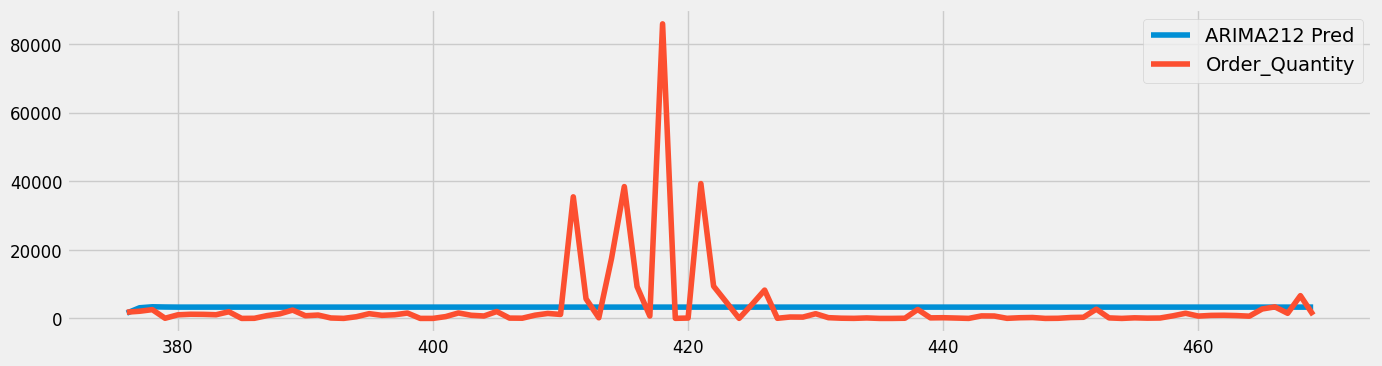

In [245]:
start=len(train)
end=len(train)+len(test)-1
pred=model212.predict(start=start,end=end).rename('ARIMA212 Pred')
pred.plot(legend=True)
test['Order_Quantity'].plot(legend=True)

In [248]:
# TRIED 0,0,1 and 2,2,1 models so not getting good prediction of seasonality level so using SARIMAX model for (2,1,2)

In [247]:
#USING SARIMAX MODEL

In [252]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model3=SARIMAX(train['Order_Quantity'],order=(2,1,2),seasonal_order=(0,1,1,12))
results=model3.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                       Order_Quantity   No. Observations:                  376
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 12)   Log Likelihood               -3933.645
Date:                              Tue, 27 Aug 2024   AIC                           7879.290
Time:                                      22:13:04   BIC                           7902.656
Sample:                                           0   HQIC                          7888.578
                                              - 376                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1948      0.401      0.486      0.627      -0.591       0.980
ar.L2         -0.0961      0.205     -0.468      0.640      -0.498       0.306
ma.L1         -0.6682      0.404     -1.654      0.098      -1.460       0.124
ma.L2         -0.2919      0.404     -0.722      0.470      -1.085       0.501
ma.S.L12      -0.8810      0.076    -11.551      0.000      -1.031      -0.732
sigma2      2.475e+08   3.96e-09   6.25e+16      0.000    2.47e+08    2.47e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             21078.53
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.77   Skew:                             4.49
Prob(H) (two-sided):                  0.14   Kurtosis:                        39.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.73e+32. Standard errors may be unstable.
"""

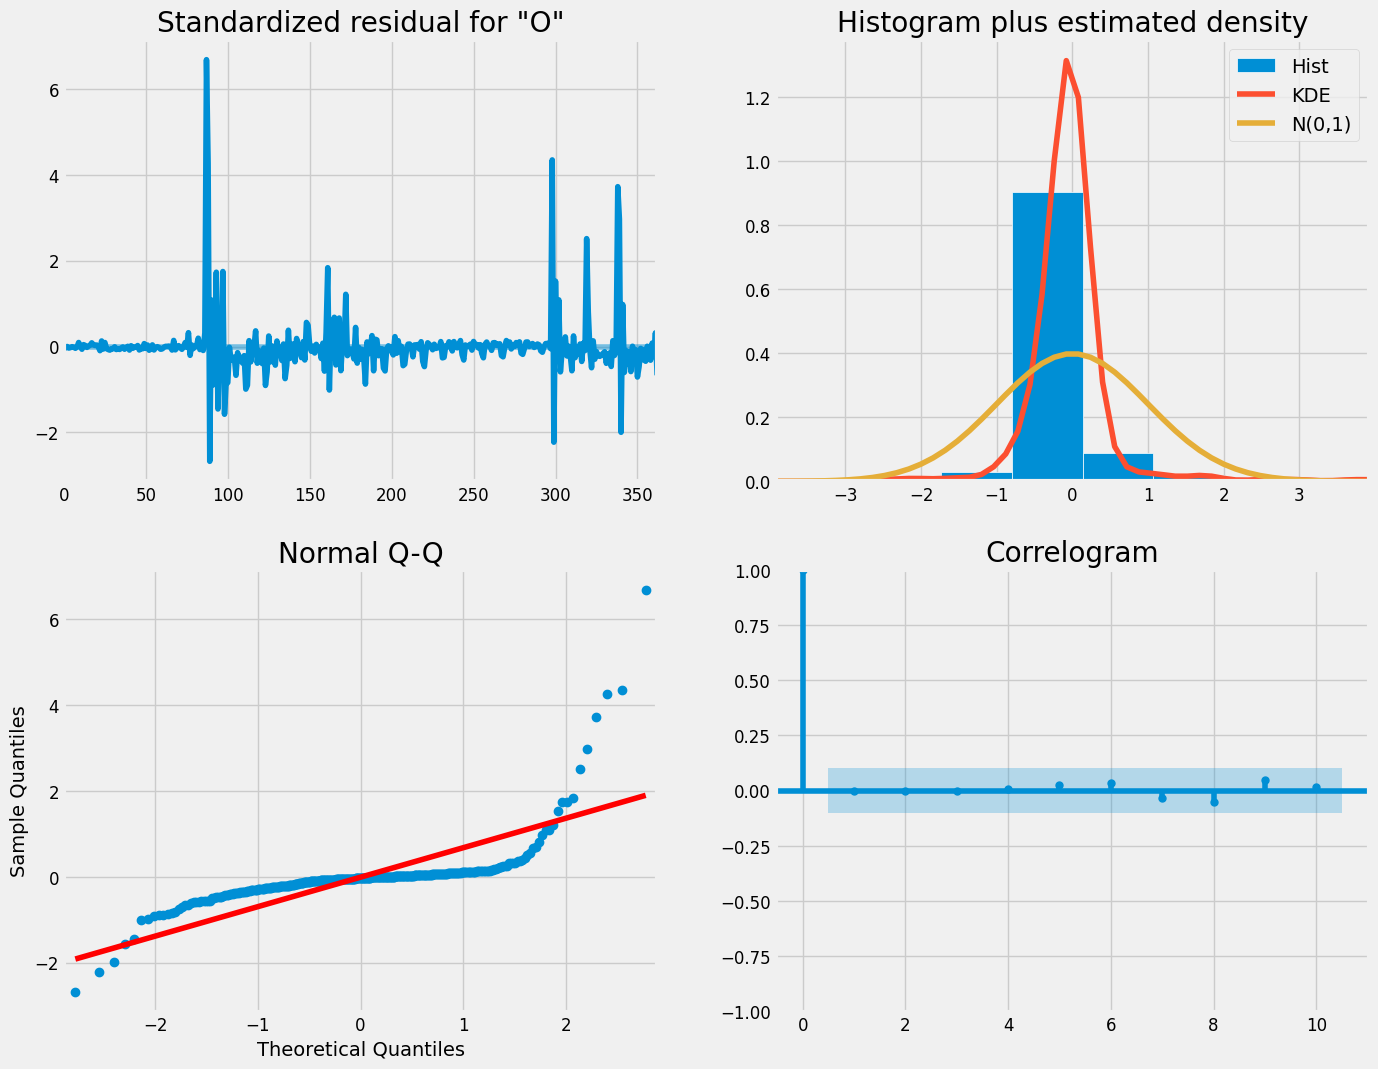

In [254]:
results.plot_diagnostics(figsize=(15,12))
plt.show()

<Axes: >

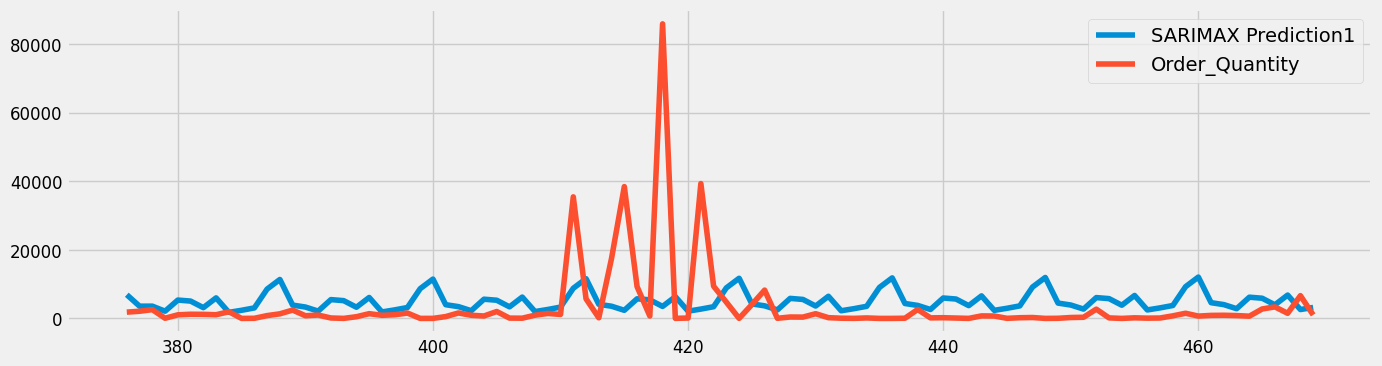

In [260]:
start=len(train)
end=len(train)+len(test)-1
pred=results.predict(start=start,end=end).rename('SARIMAX Prediction1')
pred.plot(legend=True)
test['Order_Quantity'].plot(legend=True)

In [257]:
from sklearn.metrics import mean_squared_error
from math import sqrt
test['Order_Quantity'].mean()
rmse=sqrt(mean_squared_error(pred,test["Order_Quantity"]))
print(rmse)

11558.198763191604


In [259]:
model4=SARIMAX(train['Order_Quantity'],order=(1,1,2),seasonal_order=(5,1,0,12))
model4=model4.fit()

In [261]:
index_future_dates=pd.date_range(start='2020-05-15',end='2020-05-31')
pred=model4.predict(start=len(daily_df_reset),end=len(daily_df_reset)+16).rename('SARIMAX Prediction2')
pred.index=index_future_dates
print(pred)

2020-05-15     4433.661146
2020-05-16    14778.379486
2020-05-17    20716.981023
2020-05-18     2331.730855
2020-05-19     3171.113934
2020-05-20     2683.278770
2020-05-21     8886.505353
2020-05-22     8254.022726
2020-05-23     3882.750800
2020-05-24     5112.749809
2020-05-25     2506.533301
2020-05-26     2843.581854
2020-05-27     4648.073479
2020-05-28    15292.729238
2020-05-29    21321.610368
2020-05-30     2506.873579
2020-05-31     3349.959996
Freq: D, Name: SARIMAX Prediction2, dtype: float64


In [262]:
#THE ABOVE DATA IS CHANGING AND FORECASTING DATA BUT WHERE WE CAN FIND THE 17TH MAY 2020 IS SUNDAY BUT AS PER THE RAW DATA WE FOUND THAT WEDNESDAY HAVE HIGH DEMAND SO I AM NOT CONSIDERING THIS AS GOOD MODEL

In [264]:
#NEED TO CHECK LSTM,RNN,FB PROPHET,DEEP AR ALSO THAN WE CAN SUGGEST THE CLIENT THIS WAS THE BEST MODEL